## [1. Import Needed Modules](#import) ##
## [2. Read in images and create a dataframe of image paths and class labels](#makedf) ## 
## [3. Balance the trainning set](#Balance) ##
## [4. Create train, test and validation generators](#generators) ## 
## [5. Create a function to show Training Image Samples](#show) ## 
## [6. Create the Model](#model) ## 
## [7. Create a custom Keras callback to continue or halt training](#callback) ## 
## [8. Instantiate custom callback ](#callbacks) ##
## [9. Train the model](#train) ##
## [10. Define a function to plot the training data](#plot) ##
## [11. Make predictions on test set, create Confusion Matrix and Classification Report](#result) ##
## [12 Save the model](#save) ##
## [13 Plot Validation Loss % change between epochs](#implot) ##
## [14 Analysis of the Validation Loss % change plot](#analysis) ##

<a id="import"></a>
# <center>Import Need Modules</center>

In [2]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm


<a id="makedf"></a>
# <center>Read in train, test and valid images and create train, test and validation data frames</center>

In [3]:
def make_dataframes():
    print('Enter the full path to the directory containing the train, test and valid sub directories')
    sdir=input(' ')
    dataset_names= ['train', 'test' ,'valid']
    train_path=os.path.join(sdir, 'train')
    test_path=os.path.join(sdir, 'test')
    valid_path=os.path.join(sdir, 'valid')
    path_list=[train_path, test_path, valid_path]   
    zip_list=zip(dataset_names, path_list)
    
    # generate train_df, test_df, valid_df
    for dataset, setpath in zip_list:
        filepaths=[]
        labels=[]
        classes=sorted(os.listdir(setpath))
        for klass in classes:
            classpath=os.path.join(setpath, klass)
            flist=sorted(os.listdir(classpath))           
            desc=f'{dataset:6s}-{klass:13s}'            
            for f in tqdm(flist, ncols=130, desc=desc):
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1)
        if dataset =='train':
            train_df=df
        elif dataset == 'test':
            test_df=df
        else:
            valid_df=df
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts())    
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)
    return train_df, test_df, valid_df, classes, class_count, sdir
    

In [6]:
train_df, test_df, valid_df, classes, class_count, sdir=make_dataframes()

Enter the full path to the directory containing the train, test and valid sub directories
 C:/Users/TI/Documents/fyp/DataSets/image dataset of autism


valid -non_autistic : 100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<?, ?it/s]


number of classes in processed dataset=  2
the maximum files in any class in train_df is  1263   the minimum files in any class in train_df is  1263
train_df length:  2526   test_df length:  200   valid_df length:  200
average image height=  377   average image width=  342  aspect ratio h/w=  1.1023391812865497


<a id="generators"></a>
# <center>Create the train_gen, test_gen final_test_gen and valid_gen</center>

In [11]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen = ImageDataGenerator()
    t_and_v_gen = ImageDataGenerator()
    
    train_gen = trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                          class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    
    valid_gen = t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                                class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    
    length = len(test_df)
    test_batch_size = sorted([int(length / n) for n in range(1, length + 1) if length % n == 0 and length / n <= 80],
                             reverse=True)[0]
    test_steps = int(length / test_batch_size)
    
    test_gen = t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                               class_mode='categorical', color_mode='rgb', shuffle=False,
                                               batch_size=test_batch_size)
    
    classes = list(train_gen.class_indices.keys())
    class_count = len(classes)
    
    print('test batch size: ', test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes

batch_size = 20
img_size = (200, 200)
train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes = make_gens(batch_size, train_df, test_df, valid_df, img_size)


Found 2526 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
test batch size:  50   test steps:  4  number of classes :  2


write a text file to the sdir that contains the classes information. This file named classes.txt. It can be used in association with  
the averaging_predictor.ipynb notebook. That notebook needs to know the classes information to make predictions on image files

In [12]:
content=str(classes)
for char in ['\'', '[', ']', ' ']:
    content=content.replace(char, '')
wpath=os.path.join(sdir,'classes.txt')
with open(wpath , 'w') as f:
    f.write(content)
# the file is stored in the sdir as classes.txt  

<a id="show"></a>
# <center>Create a function to show example training images</center>

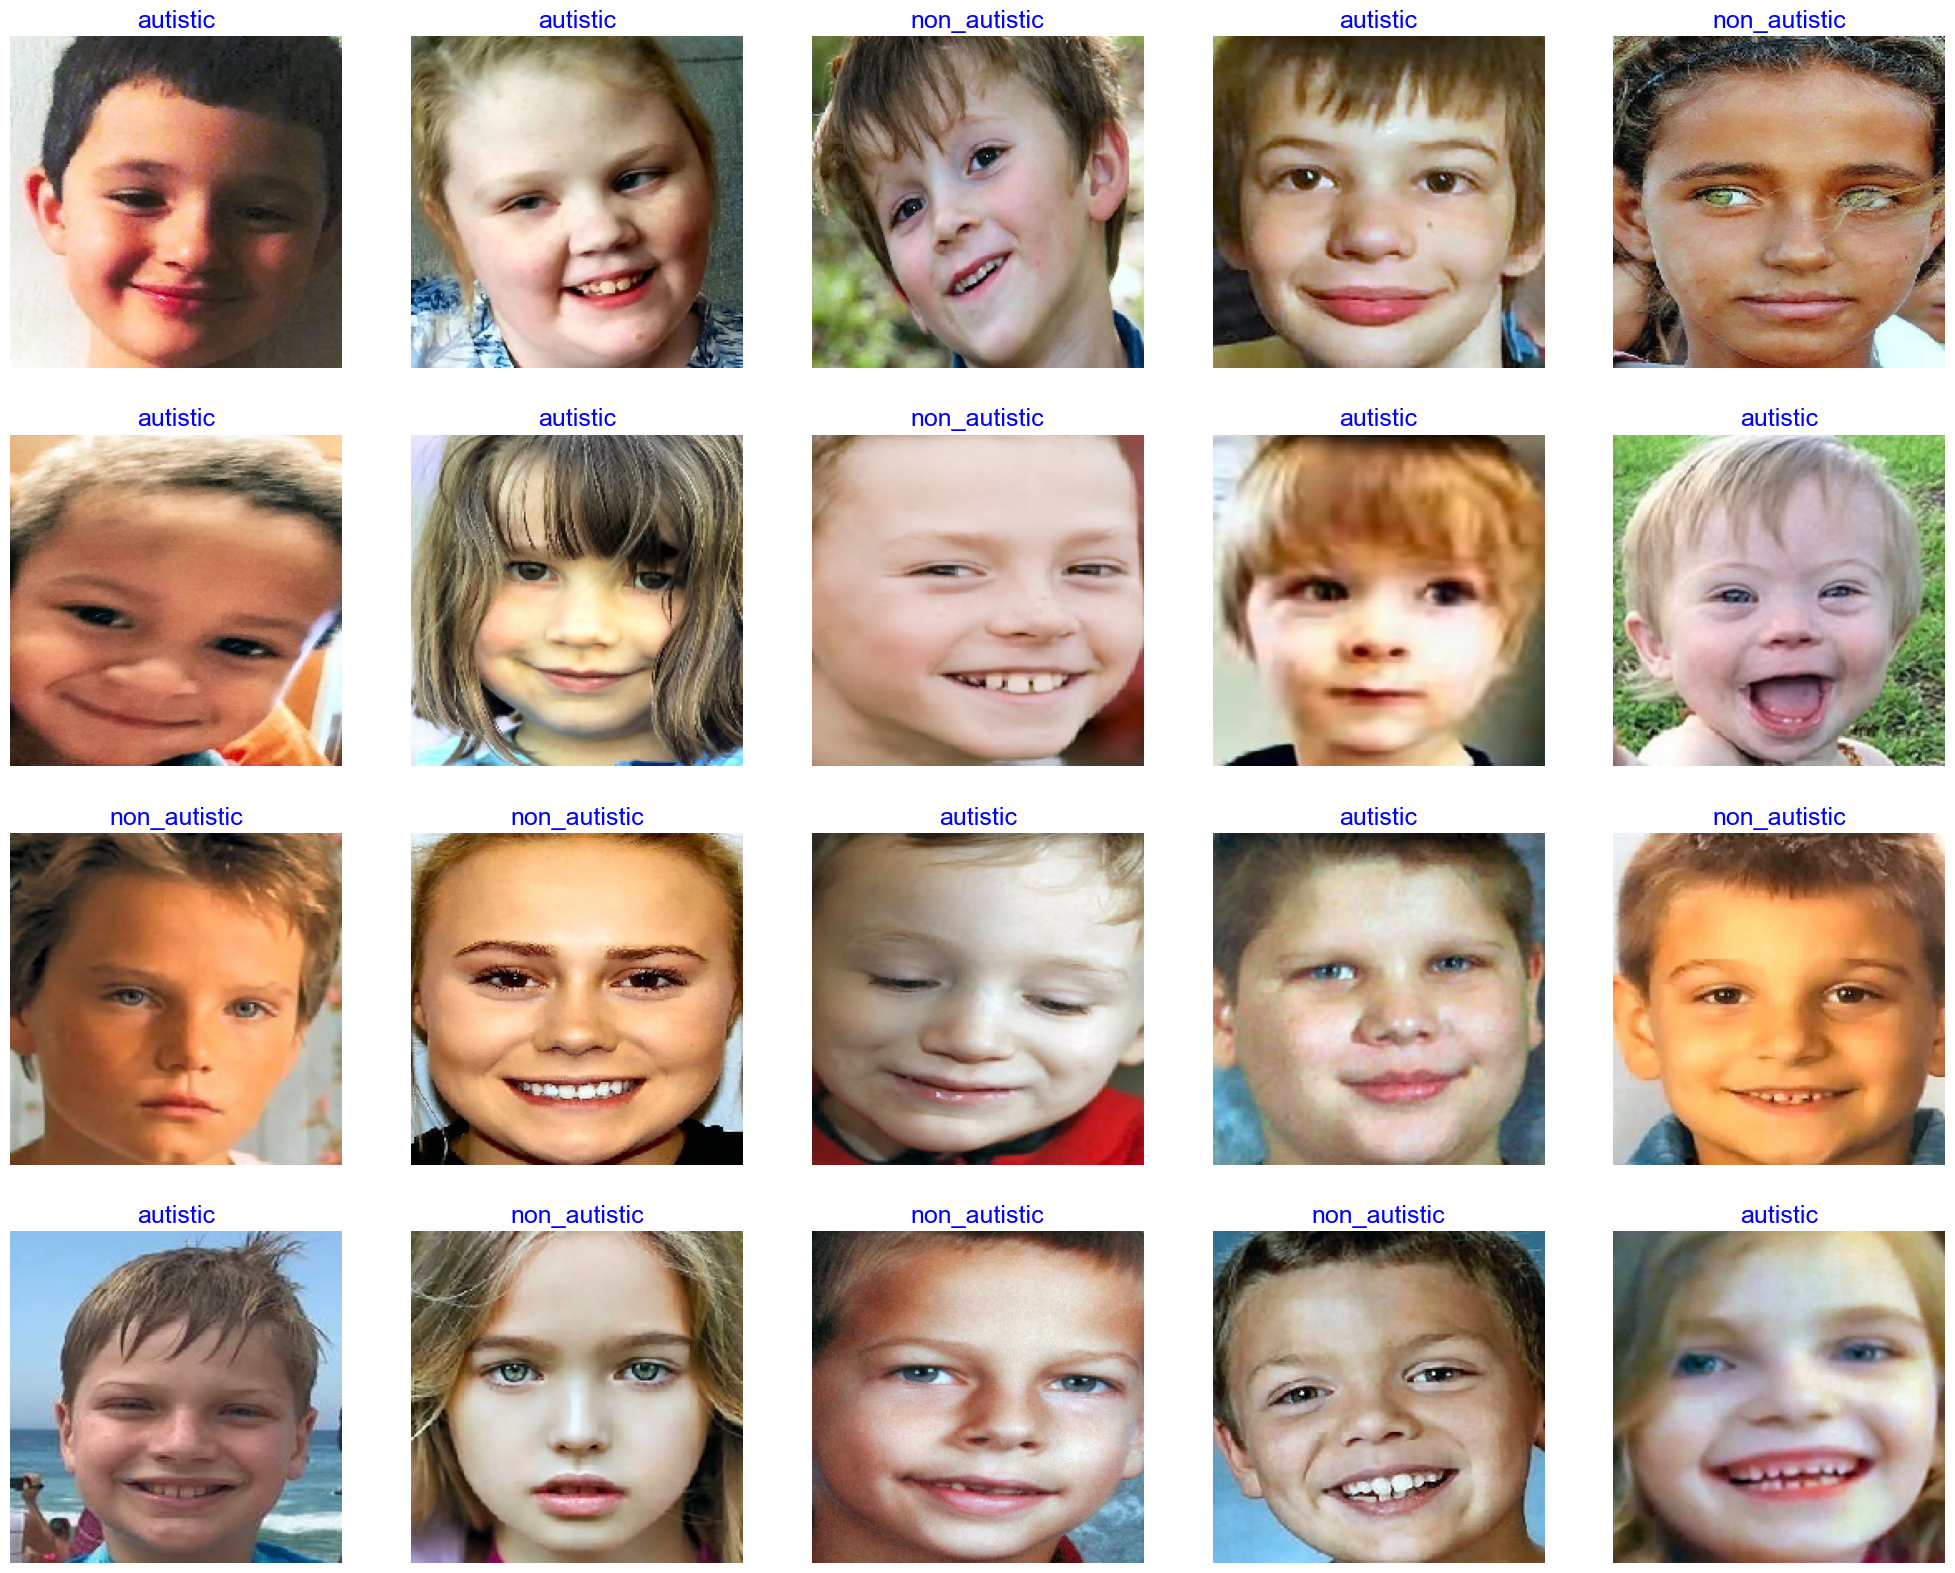

In [13]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

<a id="model"></a>
# <center>Create a model using transfer learning with EfficientNetB5</center>
### NOTE experts advise you make the base model initially not trainable when you do transfer learning.   
### Then train for some number of epochs then fine tune model by making base model trainable and run more epochs
### I have found this to be WRONG!!!!
### Making the base model trainable from the outset leads to faster convegence and a lower validation loss
### for the same number of total epochs! Insure  you initialize the transfer model with imagenet weights

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import regularizers

def make_mobilenet_model(img_size, class_count, learning_rate=0.0001):
   #leaky relu function 
    def leaky_relu(x, alpha=0.1):
        return tf.maximum(alpha * x, x)
    
    img_shape = (img_size[0], img_size[1], 3)
    
    # Load the MobileNet model, pre-trained on ImageNet
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=img_shape, pooling='max')
    
    # Make the base model trainable to fine-tune
    base_model.trainable = True
    
    # Create the custom layers on top of the base model
    x = base_model.output
    x = Flatten()(x)
   # x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dense(512, activation=lambda x: leaky_relu(x), kernel_regularizer=regularizers.l2(0.01))(x)

    x = Dropout(0.5)(x)
    output = Dense(class_count, activation='softmax')(x)
    
    # Define the model
    model = Model(inputs=base_model.input, outputs=output)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Example usage
img_size = (224, 224)  # Size of input images
class_count = 2       # Number of classes in your dataset
model = make_mobilenet_model(img_size, class_count)

# Model summary to see the structure and number of parameters
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )        

<a id="callback"></a>
# <center>Create a custom Keras callback to continue and optionally set LR or halt training</center>
The LR_ASK callback is a convenient callback that allows you to continue training for ask_epoch more epochs or to halt training.  
If you elect to continue training for more epochs you are given the option to retain the current learning rate (LR) or to  
enter a new value for the learning rate. The form of use is:  
ask=LR_ASK(model,epochs, ask_epoch) where:  
* model is a string which is the name of your compiled model
* epochs is an integer which is the number of epochs to run specified in model.fit
* ask_epoch is an integer. If ask_epoch is set to a value say 5 then the model will train for 5 epochs.  
  then the user is ask to enter H to halt training, or enter an inter value. For example if you enter 4  
  training will continue for 4 more epochs to epoch 9 then you will be queried again. Once you enter an  
  integer value you are prompted to press ENTER to continue training using the current learning rate  
  or to enter a new value for the learning rate.
 * dwell is a boolean. If set to true the function compares the validation loss for the current tp the lowest   
   validation loss thus far achieved. If the validation loss for the current epoch is larger then learning rate  
   is automatically adjust by the formulanew_lr=lr * factor where factor is a float between 0 and 1. The motivation  
   here is that if the validatio loss increased we have moved to a point in Nspace on the cost functiob surface that  
   if less favorable(higher cost) than for the epoch with the lowest cost. So the model is loaded with the weights
   from the epoch with the lowest loss and the learning rate is reduced
  
 At the end of training the model weights are set to the weights for the epoch that achieved the lowest validation loss

In [17]:
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras


        
class LR_ASK(keras.callbacks.Callback):
    def __init__(self, epochs, ask_epoch, dwell=True, factor=0.4):
        super(LR_ASK, self).__init__()
        self.ask_epoch = ask_epoch
        self.epochs = epochs
        self.ask = True  # if True query the user on a specified epoch
        self.lowest_vloss = np.inf
        self.lowest_aloss = np.inf
        # self.model and self.model.get_weights() are accessible after model is compiled and passed to this callback
        self.best_epoch = 1
        self.plist = []
        self.alist = []
        self.dwell = dwell
        self.factor = factor

    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0:
            print('You set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch = 1
        if self.ask_epoch >= self.epochs:
            print(f'ask_epoch >= epochs, will train for {self.epochs} epochs', flush=True)
            self.ask = False
        if self.epochs == 1:
            self.ask = False
        else:
            print(f'Training will proceed until epoch {self.ask_epoch}, then you will be asked to')
            print('enter H to halt training or enter an integer for how many more epochs to run then be asked again')
        self.start_time = time.time()
        self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        print(f'Loading model with weights from epoch {self.best_epoch}')
        self.model.set_weights(self.best_weights)
        tr_duration = time.time() - self.start_time
        hours, rem = divmod(tr_duration, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f'Training elapsed time was {hours} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds', flush=True)

    def on_epoch_end(self, epoch, logs=None):
        vloss = logs.get('val_loss')
        aloss = logs.get('loss')
        pimprov, aimprov = 0.0, 0.0
        if epoch > 0:
            deltav = self.lowest_vloss - vloss
            pimprov = (deltav / self.lowest_vloss) * 100
            self.plist.append(pimprov)
            deltaa = self.lowest_aloss - aloss
            aimprov = (deltaa / self.lowest_aloss) * 100
            self.alist.append(aimprov)

        if vloss < self.lowest_vloss:
            self.lowest_vloss = vloss
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1
            print(f'\nValidation loss of {vloss:7.4f} is {pimprov:7.4f}% below lowest loss, saving weights from epoch {epoch + 1} as best weights')
        else:
            print(f'\nValidation loss of {vloss:7.4f} is {abs(pimprov):7.4f}% above lowest loss of {self.lowest_vloss:7.4f}, keeping weights from epoch {self.best_epoch} as best weights')
            if self.dwell:
                self.adjust_learning_rate()

        if aloss < self.lowest_aloss:
            self.lowest_aloss = aloss

        if self.ask and (epoch + 1 == self.ask_epoch):
            self.query_user(epoch)

    def adjust_learning_rate(self):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        new_lr = lr * self.factor
        print(f'Learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}')
        tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
        self.model.set_weights(self.best_weights)

    def query_user(self, epoch):
        ans = input('\nEnter H to end training or an integer for the number of additional epochs to run then ask again: ')
        if ans in ['H', 'h', '0']:
            print(f'You entered {ans}. Training halted on epoch {epoch + 1} due to user input\n', flush=True)
            self.model.stop_training = True
        else:
            try:
                additional_epochs = int(ans)
                self.ask_epoch += additional_epochs
                if self.ask_epoch > self.epochs:
                    print(f'\nYou specified a maximum of {self.epochs} epochs; cannot train for {self.ask_epoch}', flush=True)
                else:
                    print(f'You entered {ans}. Training will continue to epoch {self.ask_epoch}', flush=True)
                    self.adjust_learning_rate_interactively()
            except ValueError:
                print('Invalid input; training will continue with current settings.')

    def adjust_learning_rate_interactively(self):
        ans = input('Current LR is {}. Hit enter to keep this LR or enter a new LR: '.format(tf.keras.backend.get_value(self.model.optimizer.lr)))
        if ans != '':
            try:
                new_lr = float(ans)
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                print(f'Changing LR to {new_lr}')
            except ValueError:
                print('Invalid input; keeping current learning rate.')


<a id="callbacks"></a>
# <center>Instantiate custom callback 

In [22]:
epochs=40
ask_epoch=5
ask=LR_ASK(model, int(epochs),  ask_epoch)
#rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
#callbacks=[rlronp, ask]
callbacks=[ask_callback]

In [24]:
epochs = 500
ask_epoch = 100
ask_callback = LR_ASK(epochs, ask_epoch)
callbacks = [ask_callback]


<a id="train"></a>
# <center>Train the model
### Note unlike how you are told it is BETTER to make the base model trainable from the outset if you are doing transfer learning
### The model will converge faster and have a lower validation losss. Ensure you initialize the transfer model with imagenet weights.  
### I have done a lot of testing running both ways hand have alwats found this to be true

In [ ]:
history = model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=valid_gen,
    validation_steps=None,  # You may set this if needed
    shuffle=False,  # Set to True if you want to shuffle the data
    initial_epoch=0
)

Training will proceed until epoch 100, then you will be asked to
enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/500
127/127 [==============================] - ETA: 0s - loss: 7.4630 - accuracy: 0.7597
Validation loss of  7.3297 is  0.0000% below lowest loss, saving weights from epoch 1 as best weights
127/127 [==============================] - 156s 1s/step - loss: 7.4630 - accuracy: 0.7597 - val_loss: 7.3297 - val_accuracy: 0.6800
Epoch 2/500
127/127 [==============================] - ETA: 0s - loss: 6.6867 - accuracy: 0.8025
Validation loss of  6.7582 is  7.7970% below lowest loss, saving weights from epoch 2 as best weights
127/127 [==============================] - 164s 1s/step - loss: 6.6867 - accuracy: 0.8025 - val_loss: 6.7582 - val_accuracy: 0.7350
Epoch 3/500
127/127 [==============================] - ETA: 0s - loss: 6.1261 - accuracy: 0.8646
Validation loss of  6.1877 is  8.4418% below lowest loss, saving weights from e

Epoch 25/500
127/127 [==============================] - ETA: 0s - loss: 3.4252 - accuracy: 0.9929
Validation loss of  4.0127 is  1.6882% below lowest loss, saving weights from epoch 25 as best weights
127/127 [==============================] - 136s 1s/step - loss: 3.4252 - accuracy: 0.9929 - val_loss: 4.0127 - val_accuracy: 0.8200
Epoch 26/500
127/127 [==============================] - ETA: 0s - loss: 3.3747 - accuracy: 0.9949
Validation loss of  3.9834 is  0.7306% below lowest loss, saving weights from epoch 26 as best weights
127/127 [==============================] - 137s 1s/step - loss: 3.3747 - accuracy: 0.9949 - val_loss: 3.9834 - val_accuracy: 0.8200
Epoch 27/500
127/127 [==============================] - ETA: 0s - loss: 3.3235 - accuracy: 0.9968
Validation loss of  3.9576 is  0.6454% below lowest loss, saving weights from epoch 27 as best weights
127/127 [==============================] - 137s 1s/step - loss: 3.3235 - accuracy: 0.9968 - val_loss: 3.9576 - val_accuracy: 0.8150
E

Epoch 50/500
127/127 [==============================] - ETA: 0s - loss: 2.3804 - accuracy: 0.9980
Validation loss of  3.0591 is  0.8244% below lowest loss, saving weights from epoch 50 as best weights
127/127 [==============================] - 158s 1s/step - loss: 2.3804 - accuracy: 0.9980 - val_loss: 3.0591 - val_accuracy: 0.8250
Epoch 51/500
127/127 [==============================] - ETA: 0s - loss: 2.3610 - accuracy: 0.9964
Validation loss of  3.0318 is  0.8931% below lowest loss, saving weights from epoch 51 as best weights
127/127 [==============================] - 156s 1s/step - loss: 2.3610 - accuracy: 0.9964 - val_loss: 3.0318 - val_accuracy: 0.8200
Epoch 52/500
127/127 [==============================] - ETA: 0s - loss: 2.3349 - accuracy: 0.9984
Validation loss of  3.0114 is  0.6731% below lowest loss, saving weights from epoch 52 as best weights
127/127 [==============================] - 161s 1s/step - loss: 2.3349 - accuracy: 0.9984 - val_loss: 3.0114 - val_accuracy: 0.8300
E

127/127 [==============================] - ETA: 0s - loss: 2.3005 - accuracy: 0.9996
Validation loss of  2.9871 is  0.4113% above lowest loss of  2.9749, keeping weights from epoch 63 as best weights
Learning rate was automatically adjusted from 0.000000 to 0.000000
127/127 [==============================] - 159s 1s/step - loss: 2.3005 - accuracy: 0.9996 - val_loss: 2.9871 - val_accuracy: 0.8300
Epoch 72/500
127/127 [==============================] - ETA: 0s - loss: 2.3017 - accuracy: 0.9988
Validation loss of  2.9821 is  0.2428% above lowest loss of  2.9749, keeping weights from epoch 63 as best weights
Learning rate was automatically adjusted from 0.000000 to 0.000000
127/127 [==============================] - 149s 1s/step - loss: 2.3017 - accuracy: 0.9988 - val_loss: 2.9821 - val_accuracy: 0.8300
Epoch 73/500
127/127 [==============================] - ETA: 0s - loss: 2.3006 - accuracy: 0.9992
Validation loss of  2.9799 is  0.1708% above lowest loss of  2.9749, keeping weights from e

Epoch 91/500
127/127 [==============================] - ETA: 0s - loss: 2.2997 - accuracy: 0.9988
Validation loss of  2.9805 is  0.1884% above lowest loss of  2.9749, keeping weights from epoch 63 as best weights
Learning rate was automatically adjusted from 0.000000 to 0.000000
127/127 [==============================] - 196s 2s/step - loss: 2.2997 - accuracy: 0.9988 - val_loss: 2.9805 - val_accuracy: 0.8300
Epoch 92/500
127/127 [==============================] - ETA: 0s - loss: 2.2993 - accuracy: 0.9996
Validation loss of  2.9799 is  0.1693% above lowest loss of  2.9749, keeping weights from epoch 63 as best weights
Learning rate was automatically adjusted from 0.000000 to 0.000000
127/127 [==============================] - 192s 2s/step - loss: 2.2993 - accuracy: 0.9996 - val_loss: 2.9799 - val_accuracy: 0.8400
Epoch 93/500
127/127 [==============================] - ETA: 0s - loss: 2.3029 - accuracy: 0.9972
Validation loss of  2.9796 is  0.1602% above lowest loss of  2.9749, keeping w

Epoch 111/500
127/127 [==============================] - ETA: 0s - loss: 2.3018 - accuracy: 0.9980
Validation loss of  2.9816 is  0.2266% above lowest loss of  2.9749, keeping weights from epoch 63 as best weights
Learning rate was automatically adjusted from 0.000000 to 0.000000
127/127 [==============================] - 193s 2s/step - loss: 2.3018 - accuracy: 0.9980 - val_loss: 2.9816 - val_accuracy: 0.8350
Epoch 112/500
127/127 [==============================] - ETA: 0s - loss: 2.3031 - accuracy: 0.9988
Validation loss of  2.9853 is  0.3494% above lowest loss of  2.9749, keeping weights from epoch 63 as best weights
Learning rate was automatically adjusted from 0.000000 to 0.000000
127/127 [==============================] - 189s 1s/step - loss: 2.3031 - accuracy: 0.9988 - val_loss: 2.9853 - val_accuracy: 0.8200
Epoch 113/500
127/127 [==============================] - ETA: 0s - loss: 2.3029 - accuracy: 0.9980
Validation loss of  2.9814 is  0.2214% above lowest loss of  2.9749, keepin

Epoch 131/500
127/127 [==============================] - ETA: 0s - loss: 2.3025 - accuracy: 0.9984
Validation loss of  2.9846 is  0.3267% above lowest loss of  2.9749, keeping weights from epoch 63 as best weights
Learning rate was automatically adjusted from 0.000000 to 0.000000
127/127 [==============================] - 147s 1s/step - loss: 2.3025 - accuracy: 0.9984 - val_loss: 2.9846 - val_accuracy: 0.8300
Epoch 132/500
127/127 [==============================] - ETA: 0s - loss: 2.3001 - accuracy: 0.9992
Validation loss of  2.9789 is  0.1353% above lowest loss of  2.9749, keeping weights from epoch 63 as best weights
Learning rate was automatically adjusted from 0.000000 to 0.000000
127/127 [==============================] - 144s 1s/step - loss: 2.3001 - accuracy: 0.9992 - val_loss: 2.9789 - val_accuracy: 0.8350
Epoch 133/500
127/127 [==============================] - ETA: 0s - loss: 2.3000 - accuracy: 1.0000
Validation loss of  2.9776 is  0.0930% above lowest loss of  2.9749, keepin

Epoch 151/500
127/127 [==============================] - ETA: 0s - loss: 2.2995 - accuracy: 1.0000
Validation loss of  2.9821 is  0.2421% above lowest loss of  2.9749, keeping weights from epoch 63 as best weights
Learning rate was automatically adjusted from 0.000000 to 0.000000
127/127 [==============================] - 146s 1s/step - loss: 2.2995 - accuracy: 1.0000 - val_loss: 2.9821 - val_accuracy: 0.8250
Epoch 152/500
127/127 [==============================] - ETA: 0s - loss: 2.3042 - accuracy: 0.9980
Validation loss of  2.9805 is  0.1887% above lowest loss of  2.9749, keeping weights from epoch 63 as best weights
Learning rate was automatically adjusted from 0.000000 to 0.000000
127/127 [==============================] - 154s 1s/step - loss: 2.3042 - accuracy: 0.9980 - val_loss: 2.9805 - val_accuracy: 0.8300
Epoch 153/500
127/127 [==============================] - ETA: 0s - loss: 2.2996 - accuracy: 0.9992
Validation loss of  2.9821 is  0.2451% above lowest loss of  2.9749, keepin

Epoch 171/500
127/127 [==============================] - ETA: 0s - loss: 2.3012 - accuracy: 0.9984
Validation loss of  2.9850 is  0.3393% above lowest loss of  2.9749, keeping weights from epoch 63 as best weights
Learning rate was automatically adjusted from 0.000000 to 0.000000
127/127 [==============================] - 136s 1s/step - loss: 2.3012 - accuracy: 0.9984 - val_loss: 2.9850 - val_accuracy: 0.8250
Epoch 172/500
127/127 [==============================] - ETA: 0s - loss: 2.3002 - accuracy: 0.9984
Validation loss of  2.9818 is  0.2337% above lowest loss of  2.9749, keeping weights from epoch 63 as best weights
Learning rate was automatically adjusted from 0.000000 to 0.000000
127/127 [==============================] - 149s 1s/step - loss: 2.3002 - accuracy: 0.9984 - val_loss: 2.9818 - val_accuracy: 0.8300
Epoch 173/500
127/127 [==============================] - ETA: 0s - loss: 2.3006 - accuracy: 0.9996
Validation loss of  2.9795 is  0.1571% above lowest loss of  2.9749, keepin

Epoch 191/500
127/127 [==============================] - ETA: 0s - loss: 2.3000 - accuracy: 0.9996
Validation loss of  2.9798 is  0.1651% above lowest loss of  2.9749, keeping weights from epoch 63 as best weights
Learning rate was automatically adjusted from 0.000000 to 0.000000
127/127 [==============================] - 174s 1s/step - loss: 2.3000 - accuracy: 0.9996 - val_loss: 2.9798 - val_accuracy: 0.8250
Epoch 192/500
127/127 [==============================] - ETA: 0s - loss: 2.2997 - accuracy: 0.9988
Validation loss of  2.9804 is  0.1854% above lowest loss of  2.9749, keeping weights from epoch 63 as best weights
Learning rate was automatically adjusted from 0.000000 to 0.000000
127/127 [==============================] - 158s 1s/step - loss: 2.2997 - accuracy: 0.9988 - val_loss: 2.9804 - val_accuracy: 0.8350
Epoch 193/500
127/127 [==============================] - ETA: 0s - loss: 2.2994 - accuracy: 1.0000
Validation loss of  2.9771 is  0.0766% above lowest loss of  2.9749, keepin

<a id="plot"></a>
# <center>Define a function to plot the training data

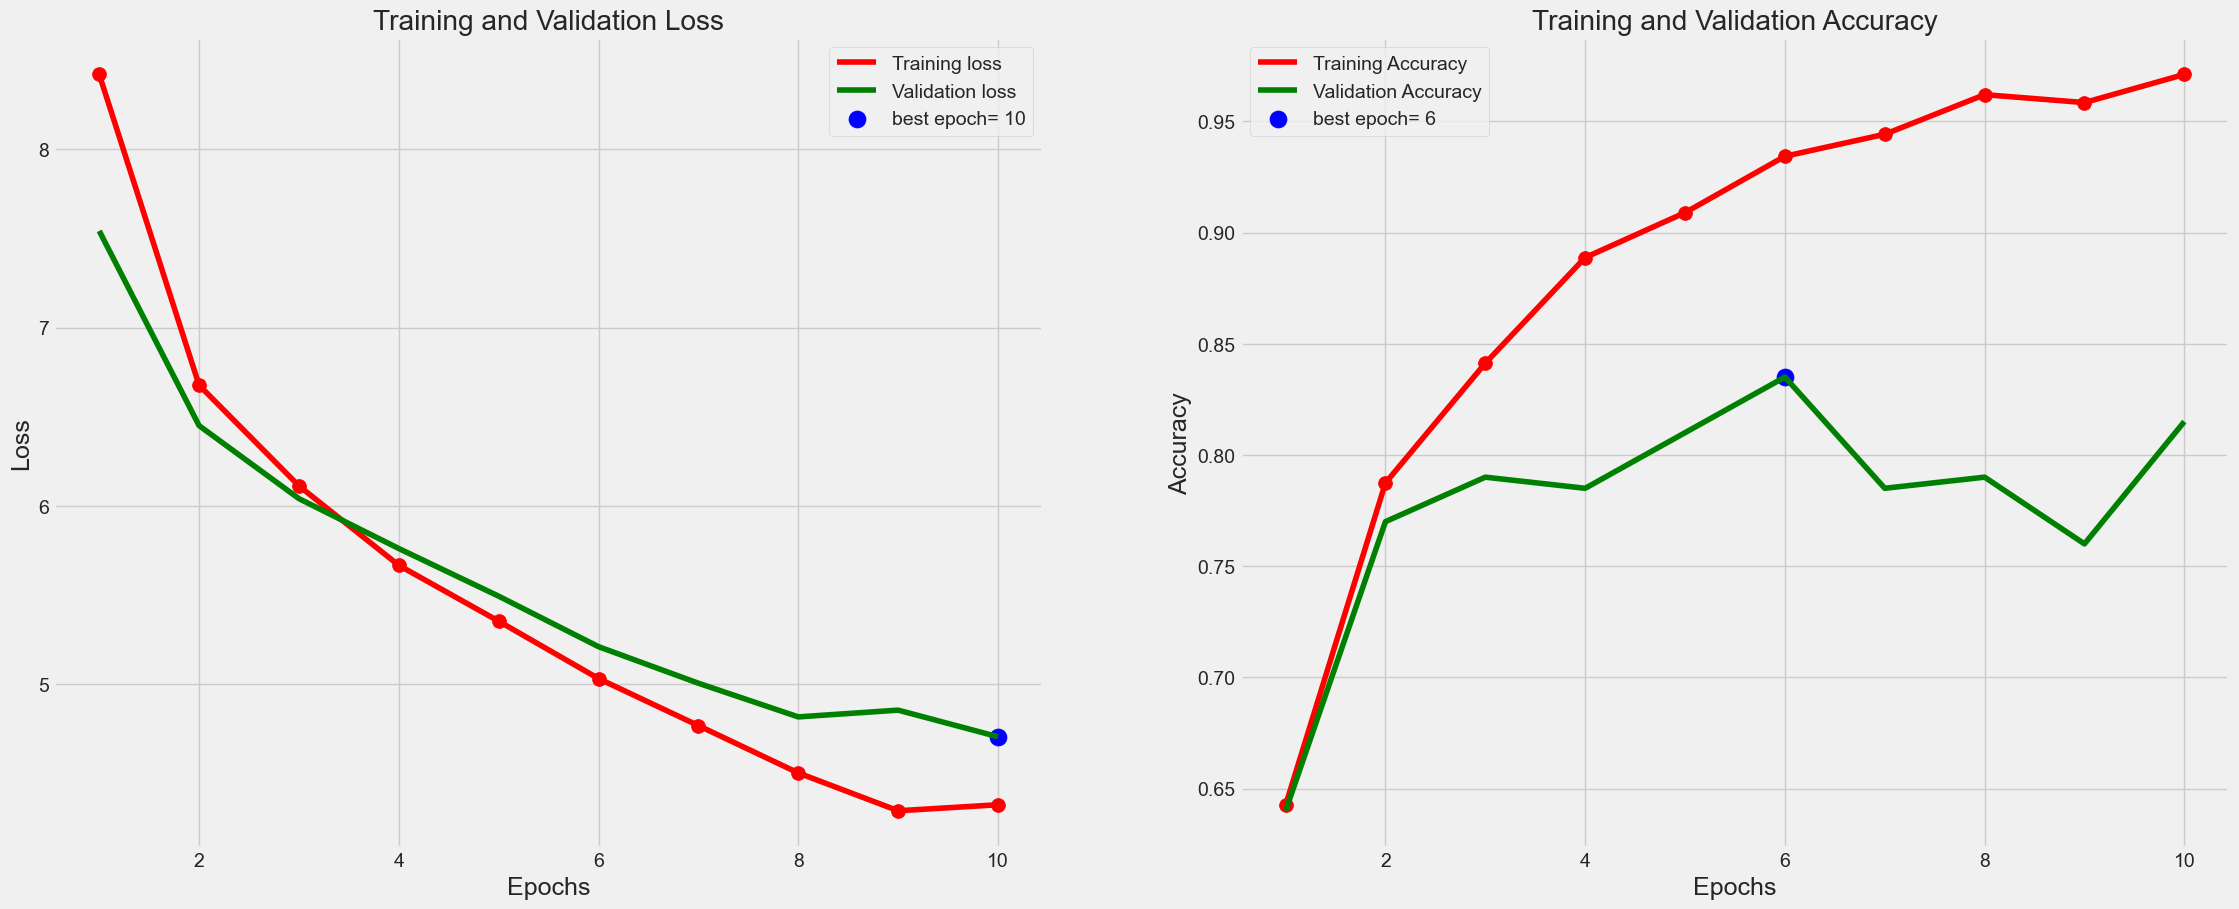

In [56]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    return index_loss
    
loss_index=tr_plot(history,0)

<a id="result"></a>
 <h3><center>Make Predictions on the test set</center></h3>
 <p>Define a function which takes in a test generator and an integer test_steps
 and generates predictions on the test set including a confusion matric
 and a classification report</p>


4/4 [==============================] - 3s 644ms/step
there were 31 errors in 200 tests for an accuracy of  84.50


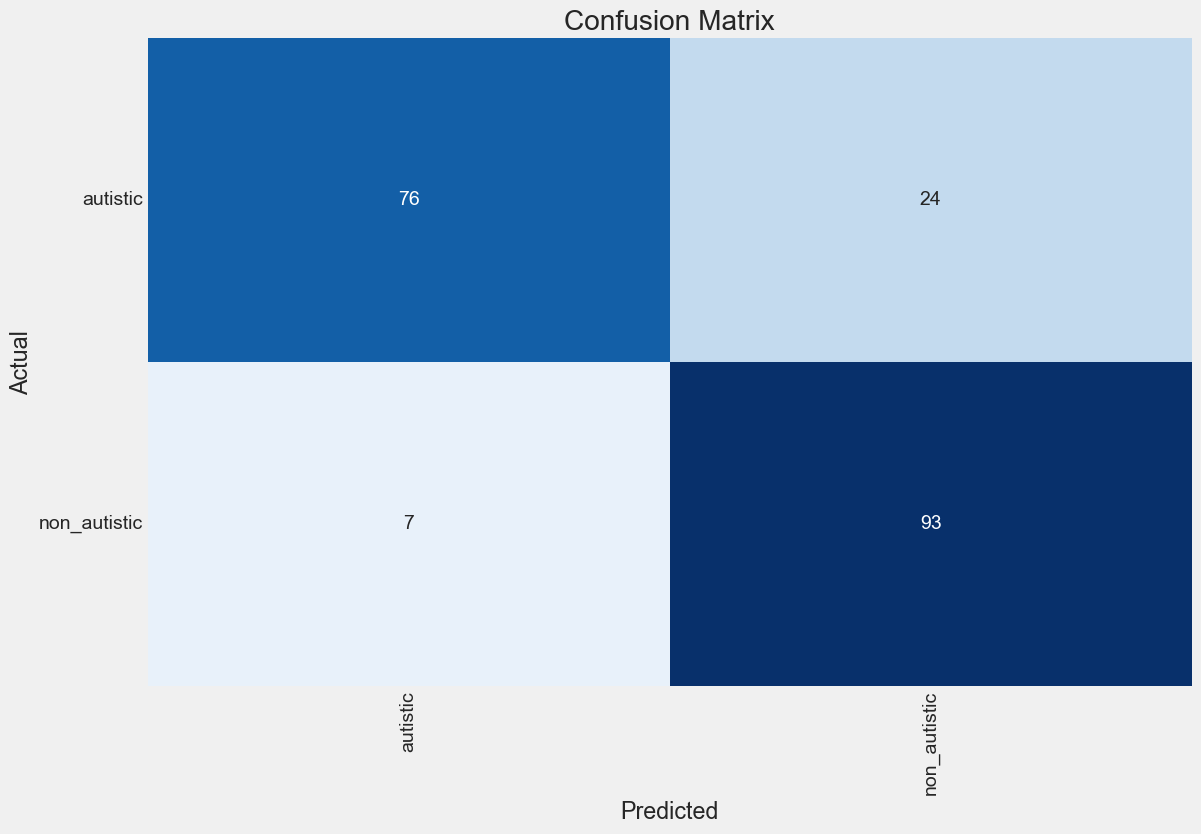

Classification Report:
----------------------
               precision    recall  f1-score   support

    autistic     0.9157    0.7600    0.8306       100
non_autistic     0.7949    0.9300    0.8571       100

    accuracy                         0.8450       200
   macro avg     0.8553    0.8450    0.8439       200
weighted avg     0.8553    0.8450    0.8439       200



In [58]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]            
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

We achieved an F1 score of 83,6% which is not to bad considering we limited the number of images in train_df to 150  
images per class and reduced the image size to 200 X 282. This was done to reduce training time at the expense of the  
F1 score. Did model did better than I expected given that the labels for the images were probably done by a human or  
humans based on a visual rather than an analytic criteria.

<a id="save"></a>
# <center>Save the model

In [59]:
working_dir=r'C:\Temp\Autism'
subject='autism-B3' 
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5' 
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc ) 
   

C:\Users\TI\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model was saved as  C:\Temp\Autism\autism-B3_84.5.h5
